# adding data and importing library


In [ ]:
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 


In [7]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     


train_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='/content/gdrive/MyDrive/Alzheimer_s Dataset/train',
                                                 shuffle=True,
                                                 target_size=(176,208), 
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='/content/gdrive/MyDrive/Alzheimer_s Dataset/train',
                                                 shuffle=True,
                                                 target_size=(176,208), 
                                                 subset="validation",
                                                 class_mode='categorical')

image_generator_submission = ImageDataGenerator(rescale=1/255) 
submission = image_generator_submission.flow_from_directory(
                                                 directory='/content/gdrive/MyDrive/Alzheimer_s Dataset/test',
                                                 shuffle=False,
                                                 target_size=(176,208), 
                                                 class_mode=None)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


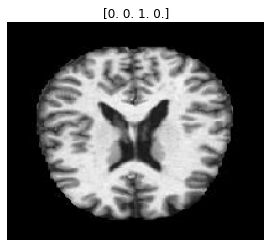

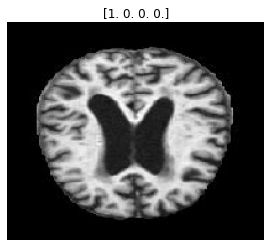

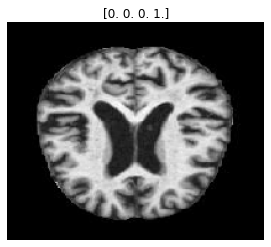

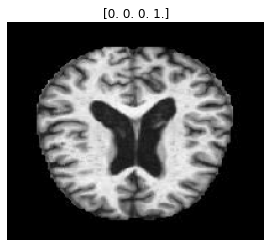

In [ ]:
batch_1_img = train_dataset[0]
for i in range(0,4):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()


#VGG 19

In [ ]:
vgg = VGG19(input_shape=(176,208,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 52, 128)       0     

In [ ]:
modelvgg.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc')])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

In [ ]:
modelvgg.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)

Epoch 1/50
283/513 [===============>..............] - ETA: 9:13 - loss: 1.0075 - auc: 0.8373

KeyboardInterrupt: ignored

In [ ]:
loss, accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

# RESnet using pytorch

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


import copy
import warnings
warnings.filterwarnings('ignore')

import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator

import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
#import shap
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from keras.utils import load_img,img_to_array


from sklearn.model_selection import train_test_split

In [8]:
W = 224
H = 224
#168

label_to_class = {
    'MildDemented': 0,
    'ModerateDemented': 1,
    'NonDemented': 2,
    'VeryMildDemented':3
    

}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name='/content/gdrive/MyDrive/Alzheimer_s Dataset', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for j in ['/train','/test']:
        for label_name in os.listdir(dir_name+str(j)):
            cls = label_to_class[label_name]

            for img_name in os.listdir('/'.join([dir_name+str(j), label_name])):
                img = load_img('/'.join([dir_name+str(j), label_name, img_name]), target_size=(W, H))
                img = img_to_array(img)

                Images.append(img)
                Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes

In [9]:
Images, Classes = get_images()

Images.shape, Classes.shape


((6400, 224, 224, 3), (6400,))

In [10]:
indices_train, indices_test = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, shuffle=False)

x_train = Images[indices_train]
y_train = Classes[indices_train]
x_test = Images[indices_test]
y_test = Classes[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape


((5120, 224, 224, 3), (5120,), (1280, 224, 224, 3), (1280,))

In [11]:
from keras.utils import np_utils
## to one-hot

y_train = keras.utils.np_utils.to_categorical(y_train, n_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, n_classes)

y_train.shape, y_test.shape

((5120, 4), (1280, 4))

In [12]:
from keras.applications.resnet import ResNet50,preprocess_input

datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    rotation_range=30,                       # randomly rotate images in the range
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,                     # randomly flip images vertically
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

In [13]:
from keras.layers import Flatten, Dense
import keras
# load model
model = keras.models.Sequential()

# load model
ResNet = ResNet50(include_top=False, input_shape=(W,H,3),pooling='avg')    
print(ResNet.summary())
# Freezing Layers

for layer in ResNet.layers:
    layer.trainable=False
    
model.add(ResNet)
model.add(Flatten())
model.add(Dense(512,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(n_classes,activation='softmax'))
model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [14]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 24,706,724
Trainable params: 1,119,012
Non

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [16]:
checkpoint_filepath = '{epoch:02d}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

earlystop = EarlyStopping(monitor = 'val_accuracy', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          mode='auto')

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, model_checkpoint_callback, reduce_lr]

In [17]:
import tensorflow as tf


In [18]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

epochs = 100
history=model.fit(datagen_train.flow(x_train,y_train, batch_size=128,shuffle=True), epochs=epochs,validation_data=datagen_test.flow(x_test,y_test, batch_size=32,shuffle=True), callbacks=callbacks )

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 1.1366 - accuracy: 0.7686 - precision: 0.5576 - recall: 0.3600 - auc: 0.7877
Epoch 1: val_accuracy improved from -inf to 0.79492, saving model to 01.h5
40/40 [==============================] - 90s 2s/step - loss: 1.1366 - accuracy: 0.7686 - precision: 0.5576 - recall: 0.3600 - auc: 0.7877 - val_loss: 0.9835 - val_accuracy: 0.7949 - val_precision: 0.6018 - val_recall: 0.5312 - val_auc: 0.8405 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.9136 - accuracy: 0.7981 - precision: 0.6530 - recall: 0.4109 - auc: 0.8419
Epoch 2: val_accuracy did not improve from 0.79492
40/40 [==============================] - 60s 1s/step - loss: 0.9136 - accuracy: 0.7981 - precision: 0.6530 - recall: 0.4109 - auc: 0.8419 - val_loss: 0.9096 - val_accuracy: 0.7943 - val_precision: 0.6277 - val_recall: 0.4359 - val_auc: 0.8430 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0

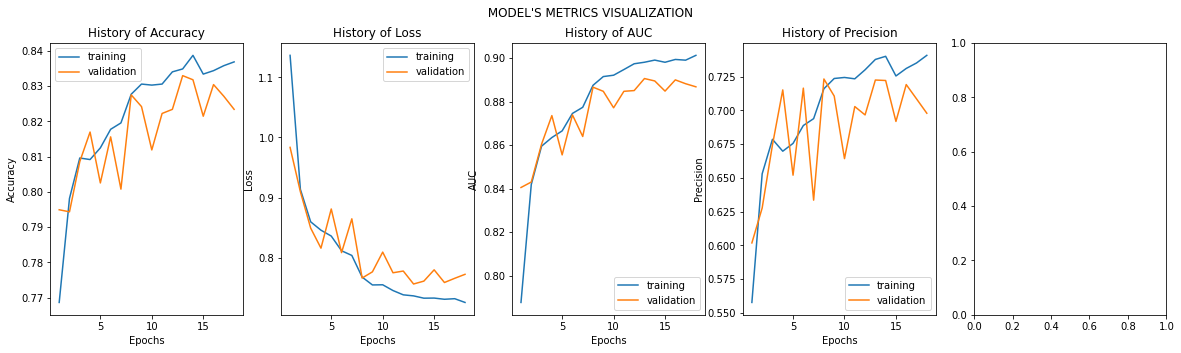

In [20]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision']              )

In [21]:
predictions=model.predict(x_test)

np.array(predictions)
CATEGORIES = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']

40/40 [==============================] - 4s 91ms/step


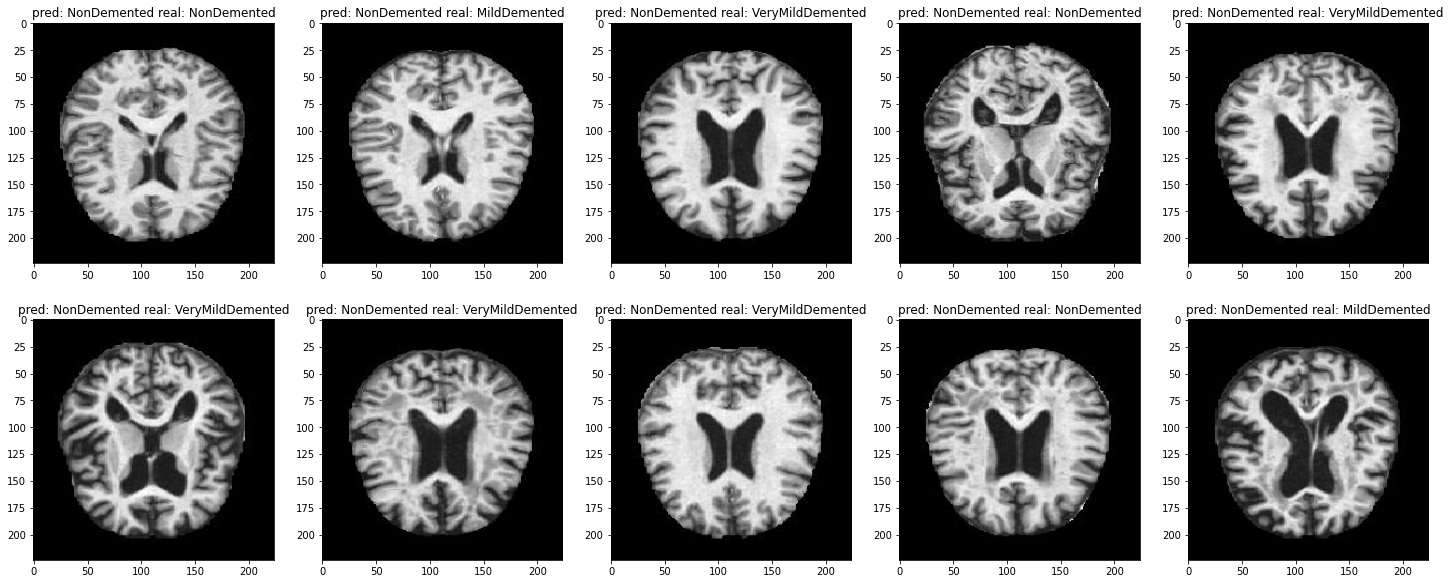

In [22]:
rows = 2
columns = 5
fig, axs= plt.subplots(rows, columns , figsize=(25, 10))
axs = axs.flatten()
i=10
for a in axs:
    
    Image = Images[i]
    pred_label=predictions.argmax(axis=1)[i]
    actual_label=y_test.argmax(axis=1)[i]
    pred_label=CATEGORIES[pred_label]
    actual_label=CATEGORIES[actual_label]
    label= 'pred: '+ pred_label +' '+'real: '+ actual_label
    #axs[i](rows,columns,i)
    a.imshow(np.uint8(Image))
    a.set_title(label)
    i=i+1

plt.show()

40/40 [==============================] - 4s 88ms/step


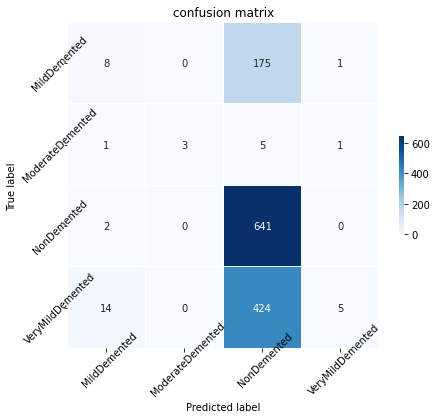

In [23]:
y_preds = model.predict(x_test)
y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [24]:
print("F1 Score (testing): %.2f%%"% (f1_score(y_trues, y_preds, average='weighted')*100.0))

F1 Score (testing): 36.34%


In [25]:
print("accuracy (testing): %.2f%%"% (accuracy_score(y_trues, y_preds)*100.0))

accuracy (testing): 51.33%


In [26]:
report = classification_report(y_trues, y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.32      0.04      0.08       184
           1       1.00      0.30      0.46        10
           2       0.51      1.00      0.68       643
           3       0.71      0.01      0.02       443

    accuracy                           0.51      1280
   macro avg       0.64      0.34      0.31      1280
weighted avg       0.56      0.51      0.36      1280

